This notebook generates an array of values (potential, velocity) for a Capytaine configuration, to visually compare with MEEM approximations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem

import pickle

import capytaine as cpt
# removes capytaine warnings from clogging outputs
import logging
logging.getLogger("capytaine").setLevel(logging.ERROR)
import copy

from capytaine_generator import CapytaineSlantSolver

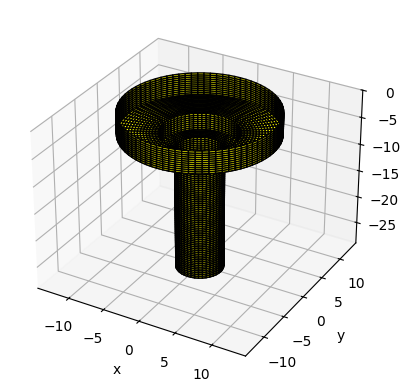

Panel Count:  5680
{'Heave': 1264335.659327109}
{'Heave': 220.72873163155853}
Solve Time (Radiation):  84.88272026198683
Solve Time (Diffraction):  0.06311706599080935
Excitation Phase:  -2.96034266006573


In [2]:
css = CapytaineSlantSolver(True, True, True, True, True)

h = 100
d_in = [29, 7, 4]
d_out = [29, 7, 4]
a = [3, 5, 10]
heaving = [0, 1, 1]
m0 = 1
rho = 1023

t_densities = [40, 60, 80]
face_units = 110 # filler

respack0 = css.construct_and_solve(a, d_in, d_out, heaving, t_densities, face_units, h, m0, rho, 1)
rad_result0 = respack0[0]

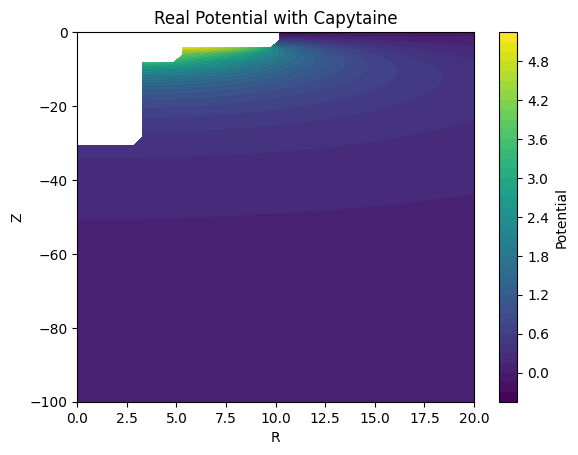

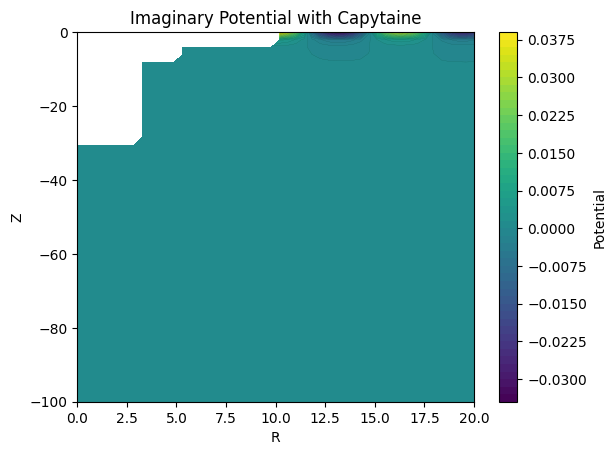

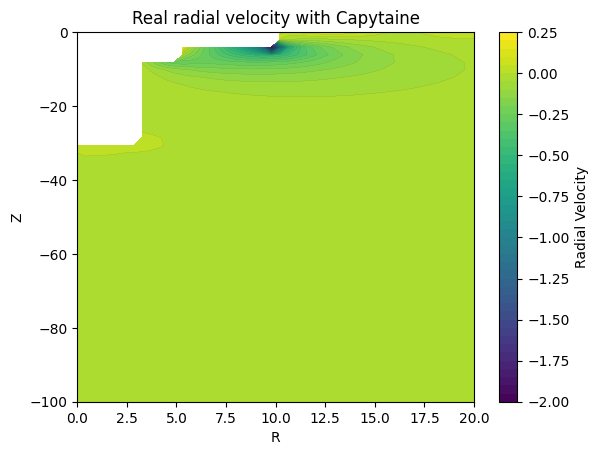

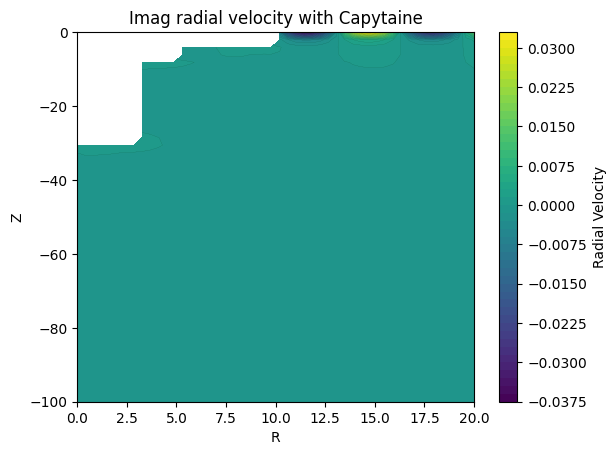

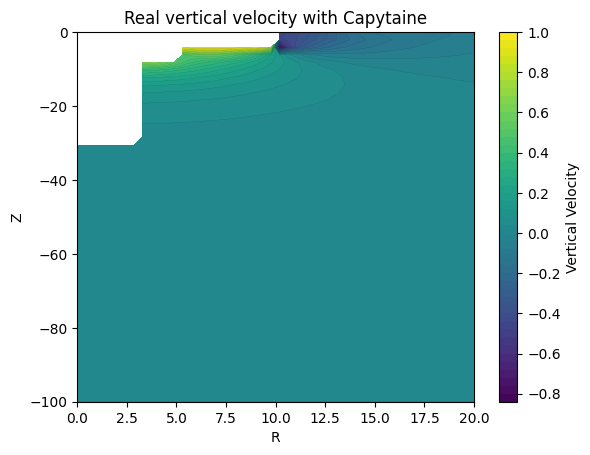

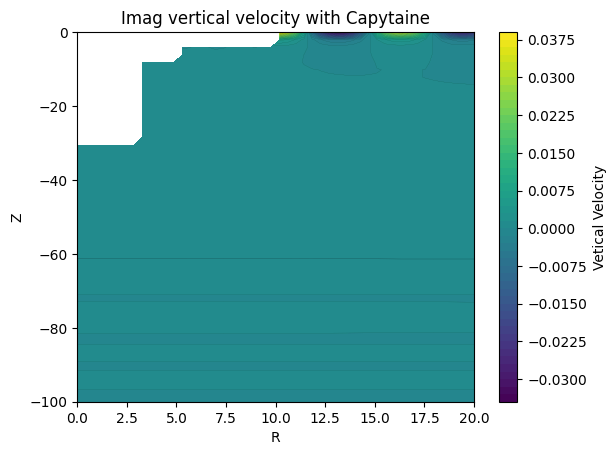

(array([[            nan,             nan,             nan, ...,
          3.88723585e-02,  3.81122965e-02,  3.29490518e-02],
        [            nan,             nan,             nan, ...,
         -8.55081392e-03, -7.38385731e-03, -6.94273702e-03],
        [            nan,             nan,             nan, ...,
         -3.25018215e-02, -2.95667277e-02, -2.70259552e-02],
        ...,
        [-1.10556553e-12, -8.93498542e-06, -1.78677336e-05, ...,
         -3.83189386e-04, -3.89830683e-04, -3.96384831e-04],
        [-1.02706746e-12, -8.81799929e-06, -1.76338232e-05, ...,
         -3.78590755e-04, -3.85169793e-04, -3.91663583e-04],
        [-1.05675593e-12, -8.57449467e-06, -1.71468932e-05, ...,
         -3.68977681e-04, -3.75424796e-04, -3.81790603e-04]]),
 array([[            nan,             nan,             nan, ...,
         -7.11398340e-03,  4.35164438e-03,  1.48648511e-02],
        [            nan,             nan,             nan, ...,
         -9.57954652e-04,  5.63201746e

In [3]:
css.plot_potential(h, a, d_in, d_out, 50, rad_result0, True)
css.plot_velocities(h, a, d_in, d_out, 50, rad_result0, True)

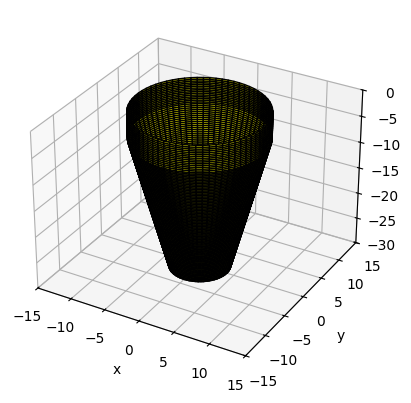

Panel Count:  6900
{'Heave': 295199.68125251366}
{'Heave': 2.483257854390664}
Solve Time (Radiation):  189.64289014600217
Solve Time (Diffraction):  0.20115778100444004
Excitation Phase:  -1.9640030808422446


In [4]:
css = CapytaineSlantSolver(True, True, True, True, True)

h = 50
a = [4, 9]
d_in = [30, 30]
d_out = [30, 5]
heaving = [0, 1]
m0 = 1
rho = 1023

t_densities = [40, 70]
face_units = 100 # filler
f_densities = [15, 75, 15]

respack = css.construct_and_solve(a, d_in, d_out, heaving, t_densities, 10, h, m0, rho, 1, f_densities)
rad_result = respack[0]

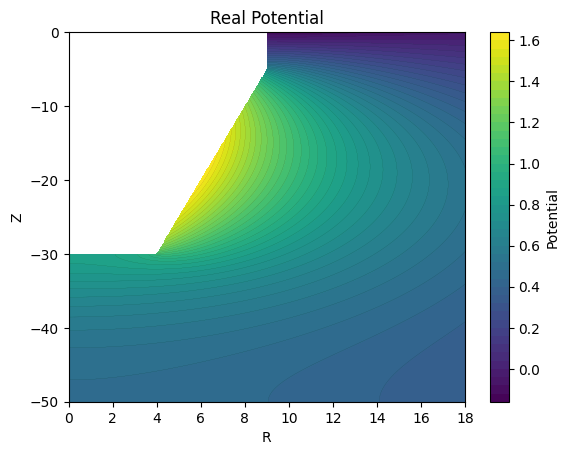

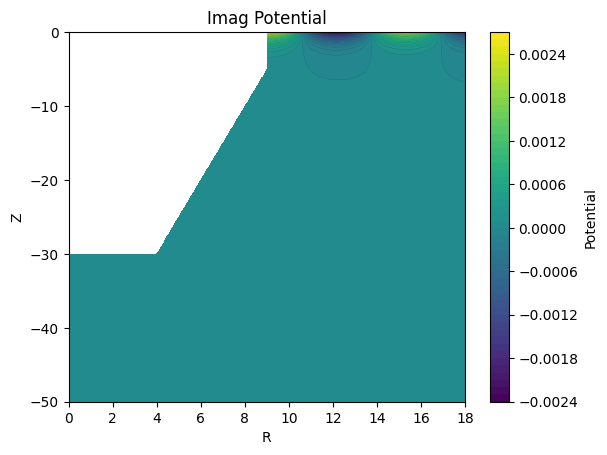

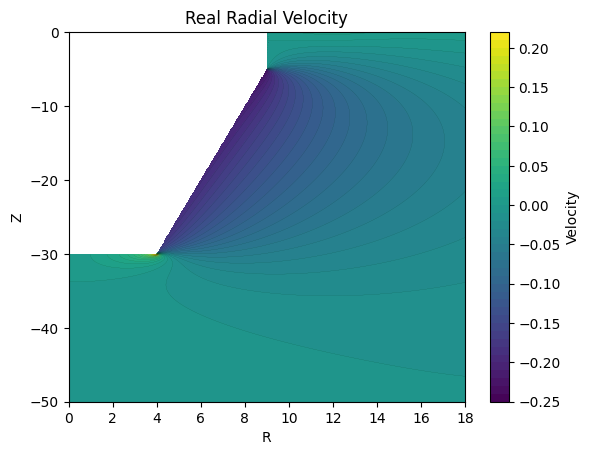

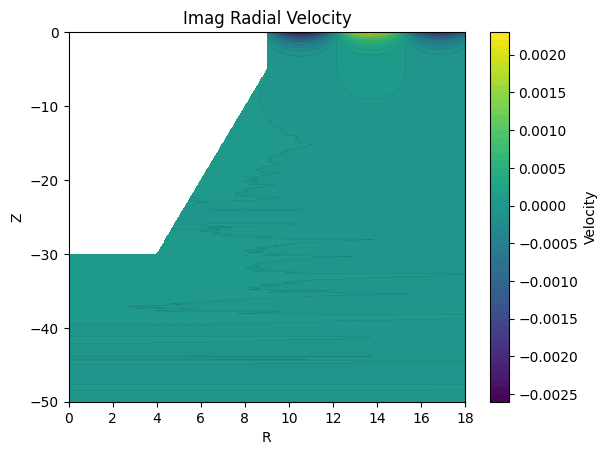

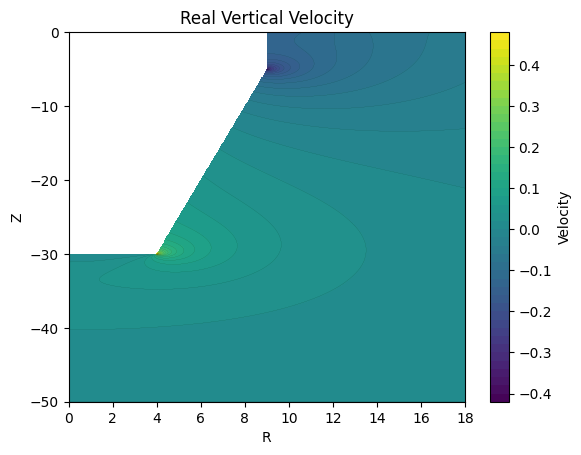

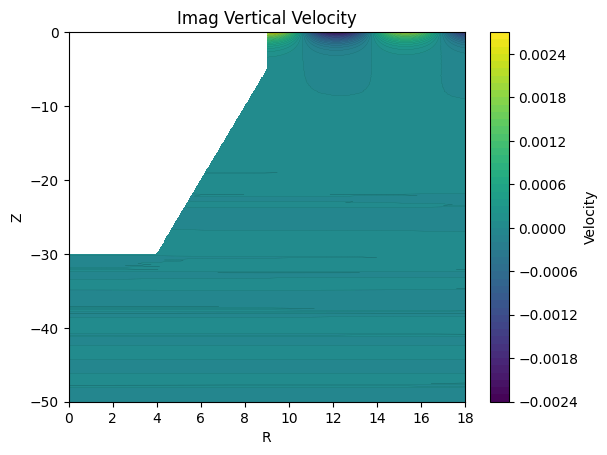

In [29]:
keys = ["Real Potential", "Imag Potential", 
        "Real Radial Velocity", "Imag Radial Velocity", 
        "Real Vertical Velocity", "Imag Vertical Velocity"]

with open("data/capytaine-point-values.pkl", "rb") as f:
  data = pickle.load(f)

for key in keys[:2]:
  css.plot_from_array(h, a, data[key], color_lab = "Potential", title = key)
for key in keys[2:]:
  css.plot_from_array(h, a, data[key], color_lab = "Velocity", title = key)

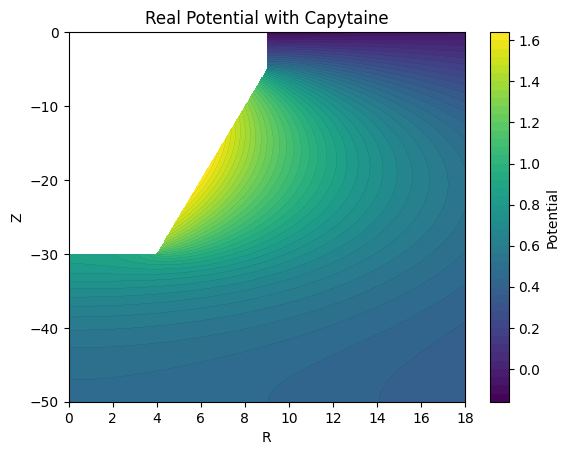

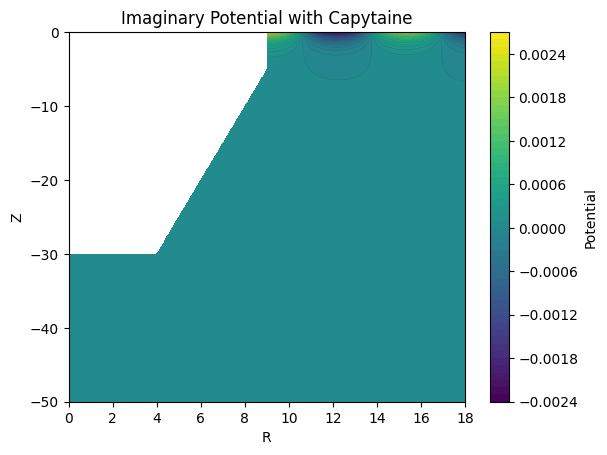

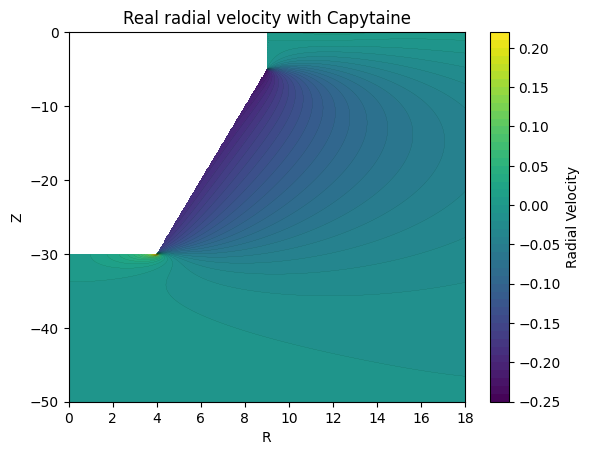

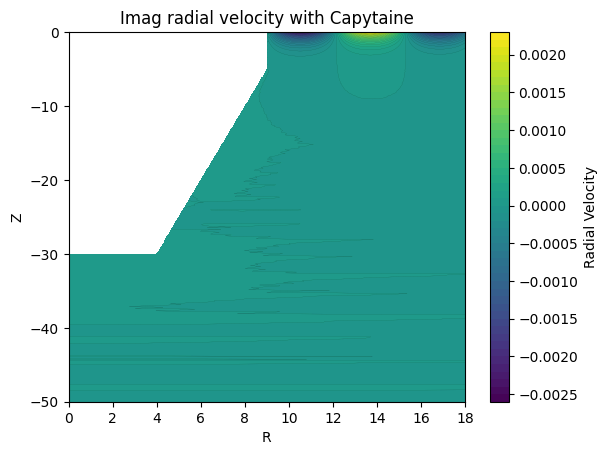

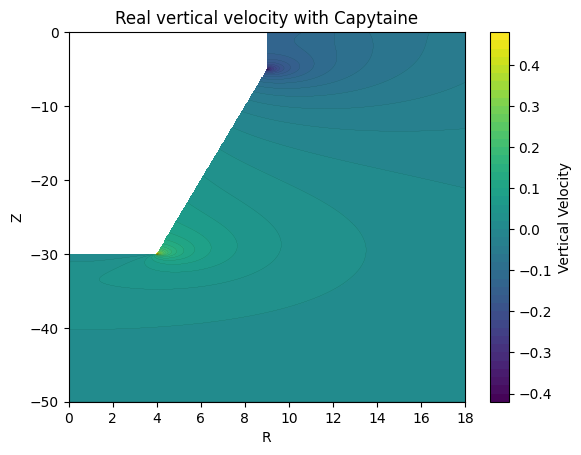

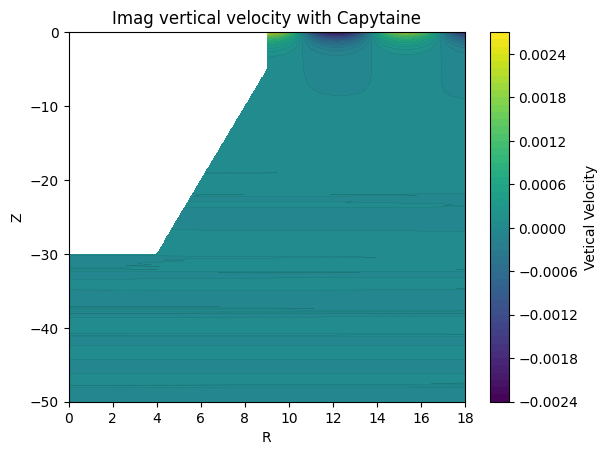

In [ ]:
# res = 400
# pot_pack = css.plot_potential(h, a, d_in, d_out, res, rad_result, True)
# vel_pack = css.plot_velocities(h, a, d_in, d_out, res, rad_result, True)
# data = {"Real Potential" : pot_pack[0],
#         "Imag Potential" : pot_pack[1],
#         "Real Radial Velocity" : vel_pack[0],
#         "Imag Radial Velocity" : vel_pack[1],
#         "Real Vertical Velocity" : vel_pack[2],
#         "Imag Vertical Velocity" : vel_pack[3],}
# with open("data/capytaine-point-values.pkl", "wb") as f:
#   pickle.dump(data, f)

In [27]:
def outline_function(r):
  region = 0
  for rad in a:
    if r <= rad: break
    else: region += 1
  if region == len(a): return 0
  elif d_in[region] == d_out[region]:
    return - d_in[region]
  else:
    inner_rad = 0 if region == 0 else a[region - 1]
    outer_rad = a[region]
    slope = (d_in[region] - d_out[region])/(outer_rad - inner_rad)
    return slope * (r - inner_rad) - d_in[region]

def plot_contour_cpt(rad_result, css, r_min, r_max, z_min, z_max, res = 50):
    # Generate grid
    r = np.linspace(r_min, r_max, res)
    z = np.linspace(z_min, z_max, res)
    R, Z = np.meshgrid(r, z)

    # Evaluate function
    def wrapper(r, z):
        if z > outline_function(r):
            return np.nan + 1j * np.nan
        else: return css.solver.compute_potential((r, 0, z), rad_result)
    vals = np.vectorize(wrapper, otypes=[complex])(R, Z) * 1j / rad_result.omega

    # Plot contour
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(R, Z, np.real(vals), cmap='viridis', levels = 50)
    plt.colorbar(contour, label='Function value')
    plt.xlabel('r')
    plt.ylabel('z')
    plt.title('Capytaine Potential')
    plt.show()

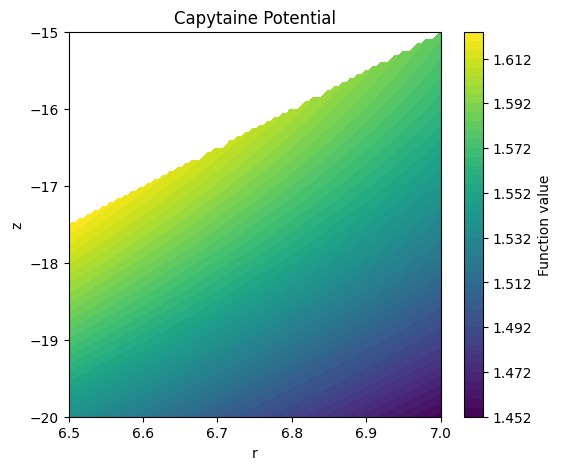

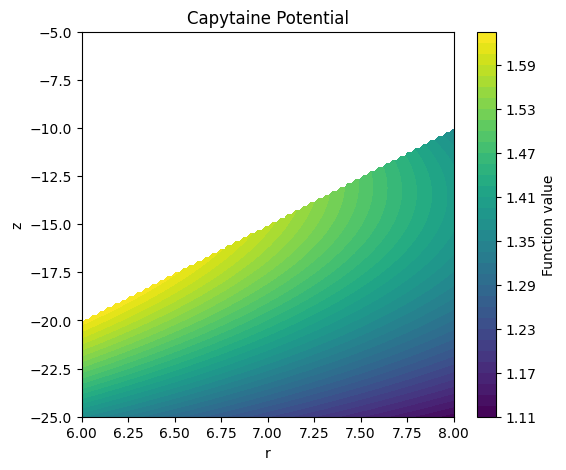

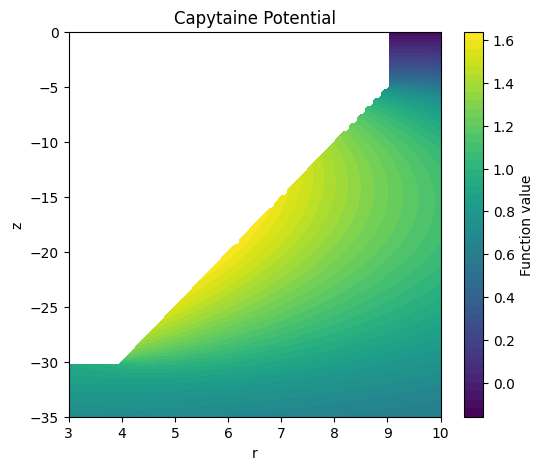

In [28]:
plot_contour_cpt(rad_result, css, 6.5, 7, -20, -15, res = 100)
plot_contour_cpt(rad_result, css, 6, 8, -25, -5, res = 100)
plot_contour_cpt(rad_result, css, 3, 10, -35, 0, res = 140)

In [17]:
class PotentialProblem(Problem):
  def det_region(self, r):
    region = 0
    for i in range(self.boundary_count):
        if r <= self.a[i]:
            return region
        else: region += 1
    return region
  
  def phi_p_i(self, r, z, i): # particular solution
      return (1 / (2* (self.h - self.d[i]))) * ((z + self.h) ** 2 - (r**2) / 2)
  
  def potential(self, r, z, cs):
    region = self.det_region(r)
    nmk = self.NMK[region]
    nmks = list(range(nmk))
    if region == self.boundary_count: # Outermost
      lambda_vals = np.vectorize(self.Lambda_k, otypes=[complex])(nmks, r)
      z_vals = np.vectorize(self.Z_k_e, otypes=[complex])(nmks, z)
      return np.dot(cs[-1], lambda_vals * z_vals)
    else:
      phi_p = 0 if not self.heaving[region] else self.phi_p_i(r, z, region)
      r1_vals = np.vectorize(self.R_1n, otypes=[complex])(nmks, r, region)
      z_vals = np.vectorize(self.Z_n_i, otypes=[complex])(nmks, z, region)
      phi_h_1 = np.dot(cs[region][:nmk], r1_vals * z_vals)
      if region == 0: # Innermost
        return phi_p + phi_h_1
      else: # Typical region
        r2_vals = np.vectorize(self.R_2n, otypes=[complex])(nmks, r, region)
        phi_h_2 = np.dot(cs[region][nmk:], r2_vals * z_vals)
        return phi_p + phi_h_1 + phi_h_2

In [33]:
# staircase with outline on exterior corners
def make_slant_region1(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
  return a_prime, d_prime

# staircase with outlines through centers, starting horizontal, end vertical
def make_slant_region2(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (0.5 + i) * delta_a)
     d_prime.append(d1 + (i) * delta_d)
  a_prime.append(a2)
  d_prime.append(d2)
  return a_prime, d_prime

# staircase with outlines through centers, starting vertical, end horizontal
def make_slant_region3(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (0.5 + i) * delta_d)
  return a_prime, d_prime

def slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version):
  if version == 1:
     make_slant_region = make_slant_region1
  elif version == 2:
     make_slant_region = make_slant_region2
  elif version == 3:
     make_slant_region = make_slant_region3
  else:
     raise ValueError
  
  a_prime = []
  d_prime = []
  heaving_prime = []
  NMK_prime = []
  slopes = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
  NMK_prime.append(NMK[-1])
  return d_prime, a_prime, heaving_prime, NMK_prime

def plot_contour_MEEM(prob, cs, r_min, r_max, z_min, z_max, res = 50):
    # Generate grid
    r = np.linspace(r_min, r_max, res)
    z = np.linspace(z_min, z_max, res)
    R, Z = np.meshgrid(r, z)

    # Evaluate function
    def wrapper(r, z):
        if z > outline_function(r):
            return np.nan + 1j * np.nan
        else: return prob.potential(r, z, cs)
    vals = np.vectorize(wrapper, otypes=[complex])(R, Z)

    # Plot contour
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(R, Z, np.real(vals), cmap='viridis', levels = 50)
    plt.colorbar(contour, label='Function value')
    plt.xlabel('r')
    plt.ylabel('z')
    plt.title('MEEM Potential')
    plt.show()

def solve_problem(prob_style, h, a, d_in, d_out, heaving, m0, rho, res, version, nmk = 150):
  NMK = [nmk, nmk, nmk]
  d_prime, a_prime, heaving_prime, NMK_prime = slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version)
  prob = prob_style(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho)
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  cs = prob.reformat_coeffs(x)
  return prob, x, cs

In [22]:
prob0, x0, cs0 = solve_problem(PotentialProblem, h, a, d_in, d_out, heaving, m0, rho, 50, 2)

In [32]:
am, dp = prob0.hydro_coeffs(x0, "capytaine")
print(am, dp)

304522.4791646488 0.38296400678411496


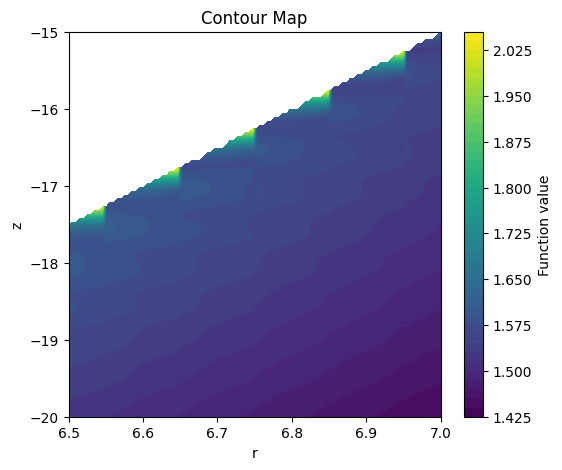

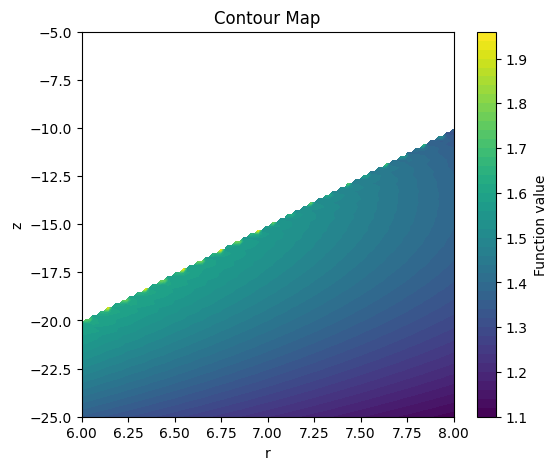

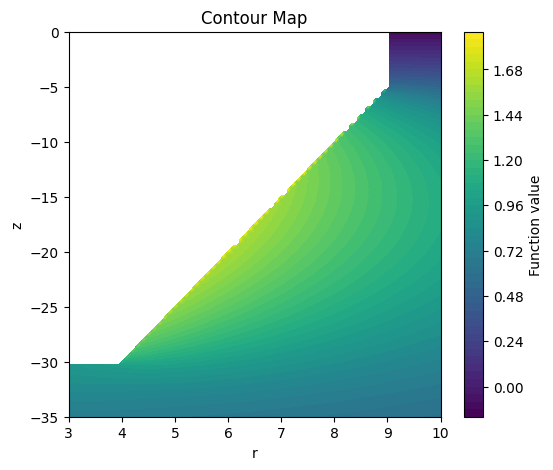

In [26]:
plot_contour_MEEM(prob0, cs0, 6.5, 7, -20, -15, res = 100)
plot_contour_MEEM(prob0, cs0, 6, 8, -25, -5, res = 100)
plot_contour_MEEM(prob0, cs0, 3, 10, -35, 0, res = 140)

In [34]:
for res in [10, 20, 30, 40]:
  prob, x, cs = solve_problem(PotentialProblem, h, a, d_in, d_out, heaving, m0, rho, res, 2, nmk = 150)
  am, dp = prob.hydro_coeffs(x, "capytaine")
  print(am, dp)

336480.3348432099 0.018267995135595554
316937.90874729387 0.13181583735847058
309898.1201339487 0.2409817432952477
306448.643169563 0.32580763872458185


In [ ]:
# R, Z, phi, nanregions = prob0.config_potential_array(cs0, 400)

In [ ]:
def plot_comparison(field, title, color):
    plt.figure(figsize=(8, 6))
    plt.contourf(R, Z, field, levels=50, cmap = color)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

def potential_comparison(p_real_cpt, p_imag_cpt, p_real_meem, p_imag_meem):

  R, Z = prob.make_R_Z(False, 400)

  plot_comparison(p_real_cpt, 'Capytaine Potential Real', "viridis")
  plot_comparison(p_real_meem, 'MEEM Potential Real', "viridis")
  plot_comparison(p_imag_cpt, 'Capytaine Potential Imaginary', "viridis")
  plot_comparison(p_imag_meem, 'MEEM Potential Imaginary', "viridis")

  meem_minus_cpt_real = p_real_meem - p_real_cpt
  meem_minus_cpt_imag = p_imag_meem - p_imag_cpt

  plot_comparison(meem_minus_cpt_real, 'Real Potential Difference', "plasma")
  plot_comparison(meem_minus_cpt_imag, 'Imag Potential Difference', "plasma")

  raw_fraction_real = (meem_minus_cpt_real)/p_real_cpt
  raw_fraction_imag = (meem_minus_cpt_imag)/p_imag_cpt

  fraction_real = classify_with_sign(raw_fraction_real)
  fraction_imag = np.where(abs(raw_fraction_imag) < 1, raw_fraction_imag, 2)

  plot_comparison(raw_fraction_real, 'Fractional Real Potential Difference', "plasma")
  plot_comparison(raw_fraction_imag, 'Fractional Imag Potential Difference', "plasma")
  plot_comparison(fraction_real, 'Fractional Real Potential Difference', "plasma")
  plot_comparison(fraction_imag, 'Fractional Imag Potential Difference', "plasma")

def replace_large_values(arr):
    return np.where(
        np.isnan(arr),           # Condition 1: keep NaNs
        np.nan,                  # Keep original NaN
        np.where(
            np.abs(arr) >= 0.1,  # Condition 2: replace large values
            0.2,                 # Replacement value
            arr                  # Keep small values
        )
    )


def classify_with_sign(arr):
    result = np.full_like(arr, np.nan, dtype=float)

    not_nan = ~np.isnan(arr)
    abs_arr = np.abs(arr[not_nan])
    signs = np.sign(arr[not_nan])

    # Build categories
    categories = np.zeros_like(abs_arr, dtype=int)
    categories[abs_arr >= 0.1] = 3
    categories[(abs_arr >= 0.05) & (abs_arr < 0.1)] = 2
    categories[(abs_arr >= 0.01) & (abs_arr < 0.05)] = 1
    categories[(abs_arr > 0.0) & (abs_arr < 0.01)] = 0
    categories[arr[not_nan] == 0.0] = 0  # explicitly handle zero

    # Reapply signs
    result[not_nan] = signs * categories

    return result

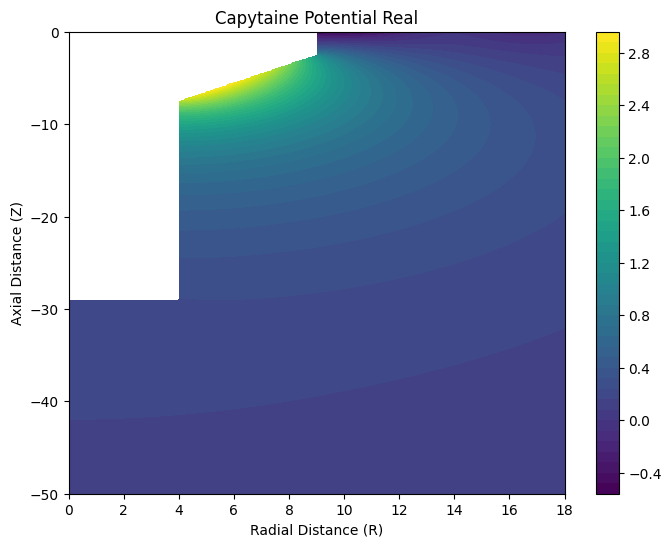

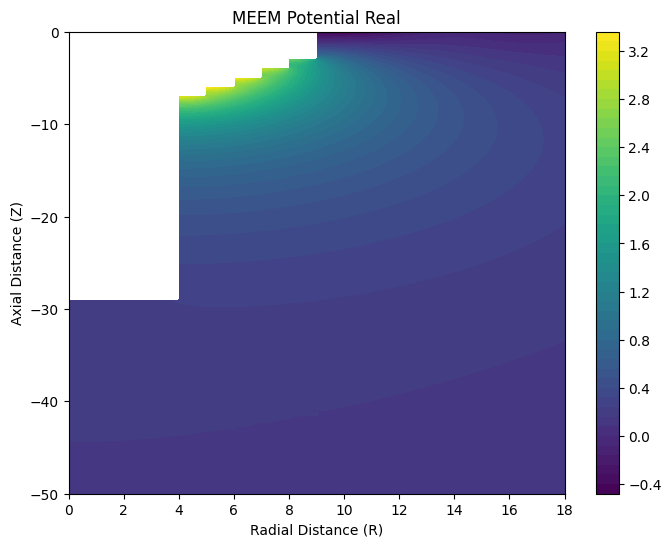

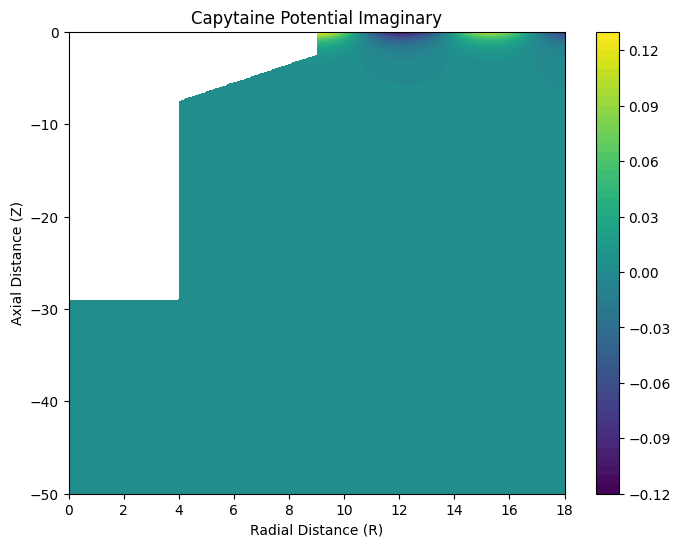

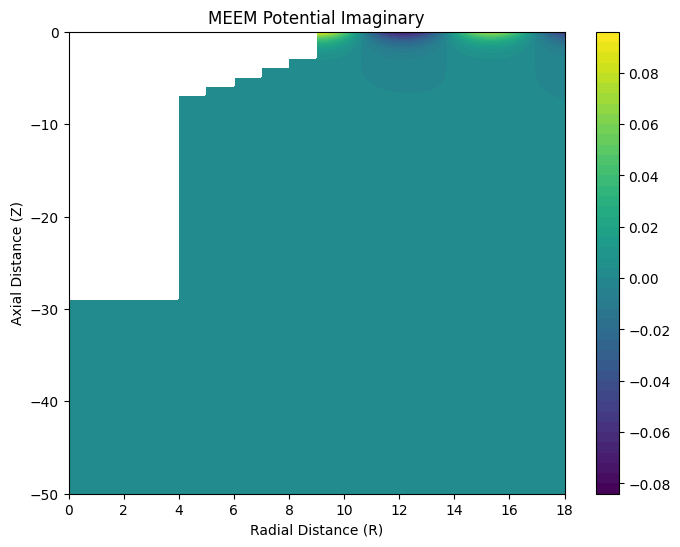

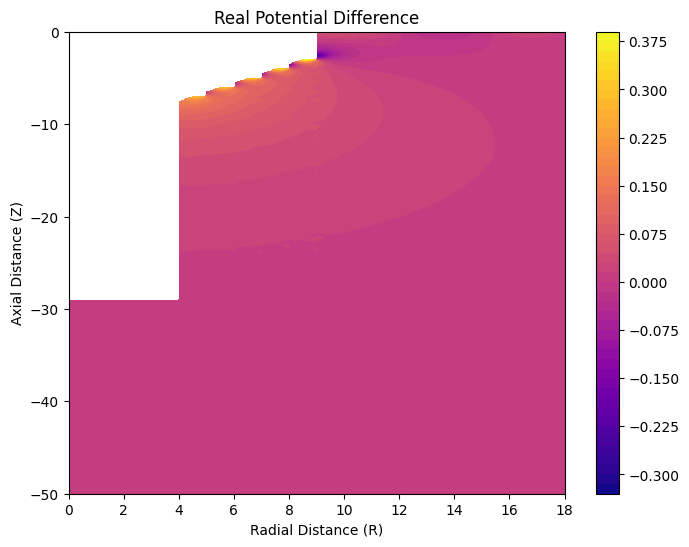

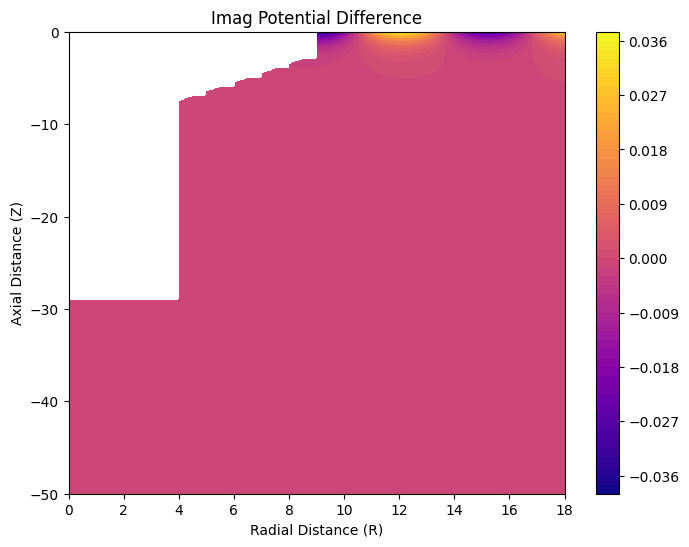

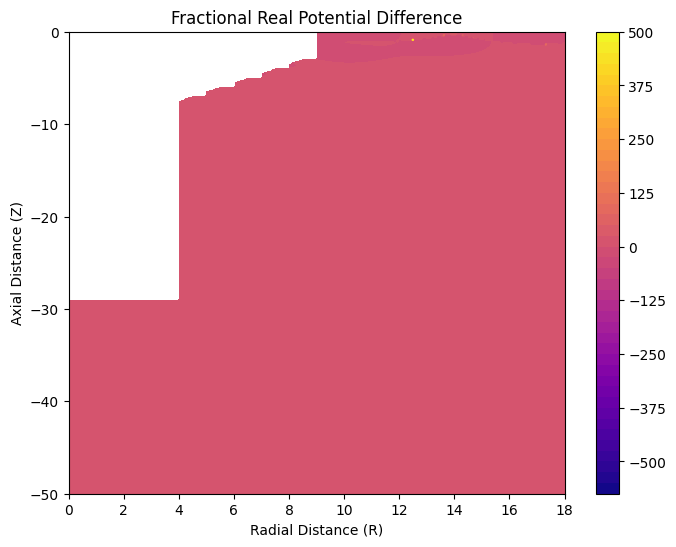

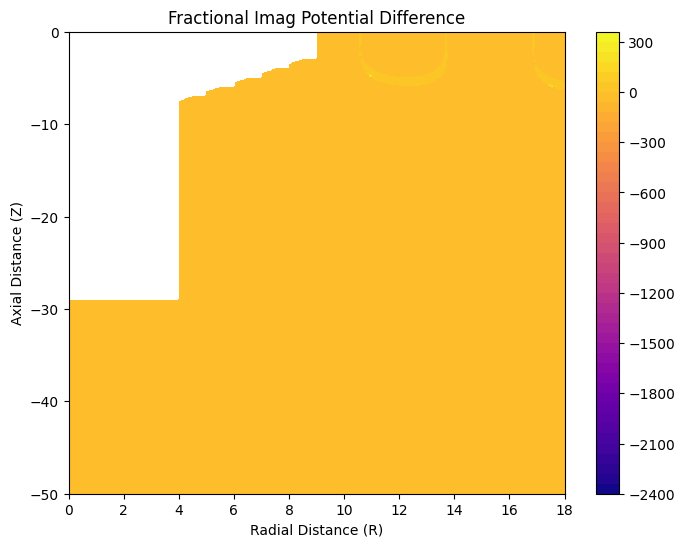

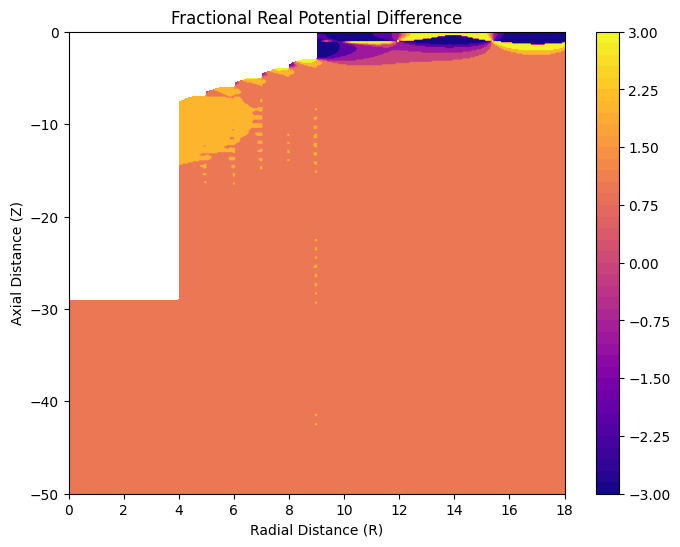

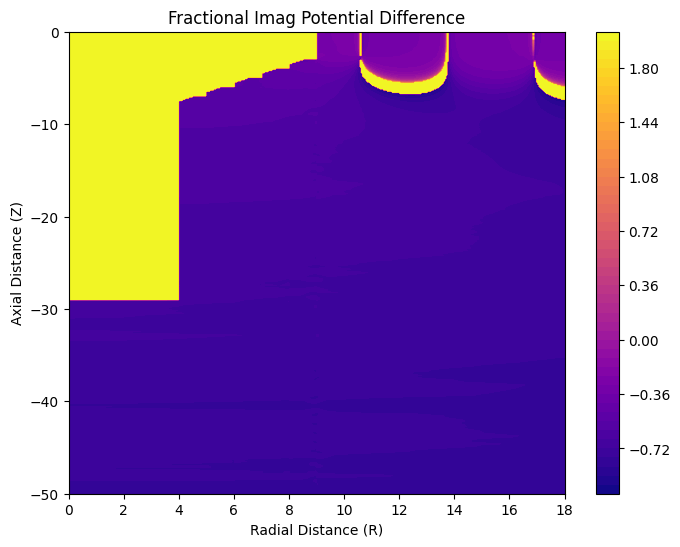

In [27]:
potential_comparison(pot_pack[0], pot_pack[1], np.real(phi), np.imag(phi))